結晶Siでの動的構造因子を確認して、実装などがおかしくないか確認する

In [2]:
#making input
from ase.io import read
atoms=read('/home/emi/lammps/crystalSi/Si.data',format='lammps-data',style='atomic')


In [3]:
import ase.build
elements = ['Si']
atoms = ase.build.sort(atoms)
atomic_numbers = atoms.get_atomic_numbers()
atoms.set_chemical_symbols([elements[i-1] for i in atomic_numbers])   

In [4]:
P=[[2,0,0],[0,2,0],[0,0,2]]
super=ase.build.make_supercell(atoms,P) 

In [5]:
super

Atoms(symbols='Si512', pbc=True, cell=[21.6027184, 21.6027184, 21.6027184], id=..., masses=..., type=...)

In [6]:
from ase.io import write
write('cSi.data',super,format='lammps-data')
write('cSi.vasp',super,format='vasp',vasp5=True)

In [7]:
import numpy as np
natom=len(super)
nmodes=natom*3
dyn_file='/home/emi/lammps/crystalSi/Dyn.form'
lammps_dyn=np.loadtxt(dyn_file).reshape((nmodes,nmodes))
eigenvalue, eigenvector=np.linalg.eigh(lammps_dyn)

Dynamical matrixのヒートマップ表示を試してみる

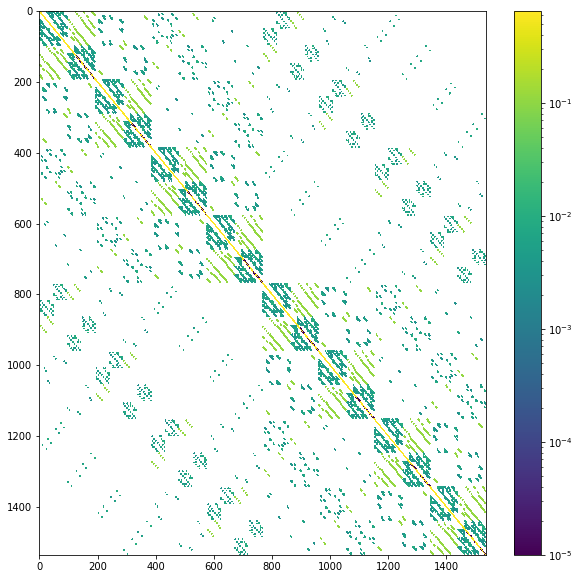

In [23]:
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
c=ax.pcolor(lammps_dyn,norm=colors.LogNorm(vmin=1e-5, vmax=lammps_dyn.max()))
ax.invert_yaxis()
fig.colorbar(c,ax=ax)

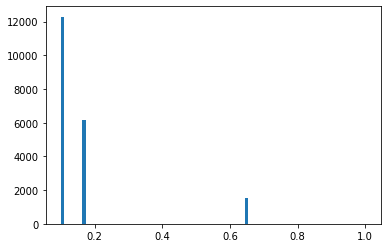

In [31]:
ebin=np.linspace(0.1,1.0,100)
plt.hist(np.ravel(np.abs(lammps_dyn)),bins=ebin)
plt.savefig('hist_dyn_cSi.png',dpi=600)

In [9]:
kmin=2.0*np.pi/super.cell[0,0]

In [10]:
kmax=kmin*10
kvec=np.linspace(kmin*0.5,kmax,20)
n_kpt=len(kvec)

In [11]:
kvec

array([0.1454258 , 0.2908516 , 0.43627741, 0.58170321, 0.72712901,
       0.87255481, 1.01798062, 1.16340642, 1.30883222, 1.45425802,
       1.59968382, 1.74510963, 1.89053543, 2.03596123, 2.18138703,
       2.32681284, 2.47223864, 2.61766444, 2.76309024, 2.90851604])

In [12]:
import pyAF.constants
pc=pyAF.constants.physical_constants()
omega=[]
nmodes=len(eigenvalue)
#extract minimum index of negative frequency
mode_negative=0
for i in range(nmodes):
    if eigenvalue[i] <0.0:
        val=0
        omega.append(val)
        mode_negative=i
    else:
        val=np.sqrt(eigenvalue[i])*pc.scale_THz
        omega.append(val)

energy THz 3.3345378344618033, energy meV 13.790548085848647


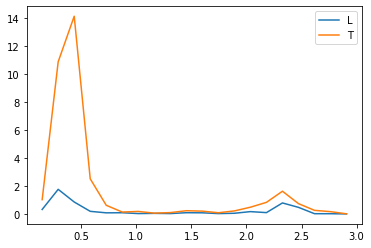

In [13]:
import pyAF.postprocess

#cheking Fourier component

id=50
n_sample=10
E=omega[id]
print(f'energy THz {E}, energy meV {E*4.13567}')
position=super.positions
ev=eigenvector[:,id]

C_L=[]
C_T=[]
for k in kvec:
    k_vector=pyAF.postprocess.polar_coord_sampling(n_sample,k)
    tmp_L=np.zeros(n_sample*n_sample)
    tmp_T=np.zeros(n_sample*n_sample)
    for i,vec in enumerate(k_vector):

        unit_vector_L=vec/np.linalg.norm(vec)
        tmp_L[i], tmp_T[i]=pyAF.postprocess.get_Ci_ver2(ev,position,vec)
    C_L.append(np.mean(tmp_L))
    C_T.append(np.mean(tmp_T))


import matplotlib.pyplot as plt
plt.plot(kvec,C_L,label='L')
plt.plot(kvec,C_T,label='T')
plt.legend()

結晶なので、[100],[010],[001]方向の平均を取るほうが妥当な値が得られる

In [14]:
from tqdm import tqdm
import pyAF.postprocess
n_sample=8
n_modes=natom*3
C_L=np.zeros((n_kpt,n_modes))
C_T=np.zeros((n_kpt,n_modes))
position=super.positions

for ik,k in enumerate(tqdm(kvec)):
    #k_vector=pyAF.postprocess.polar_coord_sampling(n_sample,k)

    for imode in range(nmodes):
        ev=eigenvector[:,imode]

        cl, ct=pyAF.postprocess.get_Ci_ver3(ev,position,k)
        C_L[ik,imode]=cl
        C_T[ik,imode]=ct

100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


In [15]:
mesh_energy=np.linspace(0,15,100)
import pyAF.postprocess
dsf_L, dsf_T=pyAF.postprocess.dynamic_structure_factor(C_L=C_L, C_T=C_T, mesh_energy=mesh_energy, frequency=omega, smearing=0.1)

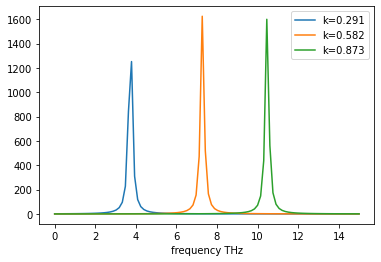

In [16]:
import matplotlib.pyplot as plt
plt.plot(mesh_energy,dsf_L[1,:],label='k={0:.3f}'.format(kvec[1]))
plt.plot(mesh_energy,dsf_L[3,:],label='k={0:.3f}'.format(kvec[3]))
plt.plot(mesh_energy,dsf_L[5,:],label='k={0:.3f}'.format(kvec[5]))

plt.xlabel('frequency THz')
plt.legend()
plt.savefig('S_L_v3_cSi.png',dpi=600)

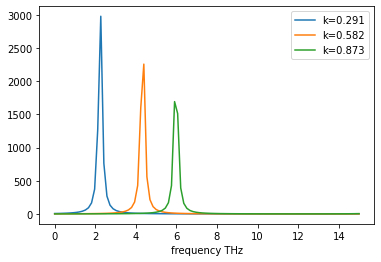

In [17]:
import matplotlib.pyplot as plt
plt.plot(mesh_energy,dsf_T[1,:],label='k={0:.3f}'.format(kvec[1]))
plt.plot(mesh_energy,dsf_T[3,:],label='k={0:.3f}'.format(kvec[3]))
plt.plot(mesh_energy,dsf_T[5,:],label='k={0:.3f}'.format(kvec[5]))

plt.xlabel('frequency THz')
plt.legend()
plt.savefig('S_T_v3_cSi.png',dpi=600)

amorphousで使っているいろいろな方向をとって平均を取る方法

In [18]:
C_L=np.zeros((n_kpt,n_modes))
C_T=np.zeros((n_kpt,n_modes))

for ik,k in enumerate(tqdm(kvec)):
    k_vector=pyAF.postprocess.polar_coord_sampling(n_sample,k)

    for imode in range(nmodes):
        ev=eigenvector[:,imode]
        tmp_L=np.zeros(n_sample*n_sample)
        tmp_T=np.zeros(n_sample*n_sample)
        for i,vec in enumerate(k_vector):

            unit_vector_L=vec/np.linalg.norm(vec)
            tmp_L[i], tmp_T[i]=pyAF.postprocess.get_Ci_ver2(ev,position,vec)
        C_L[ik,imode]=np.mean(tmp_L)
        C_T[ik,imode]=np.mean(tmp_T)

100%|██████████| 20/20 [06:21<00:00, 19.05s/it]


In [19]:
mesh_energy=np.linspace(0,15,100)
import pyAF.postprocess
dsf_L, dsf_T=pyAF.postprocess.dynamic_structure_factor(C_L=C_L, C_T=C_T, mesh_energy=mesh_energy, frequency=omega, smearing=0.1)

複数の方向の成分の平均をとっているので、いくつかのピークが生じる

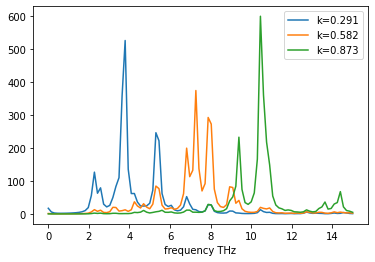

In [20]:
import matplotlib.pyplot as plt
plt.plot(mesh_energy,dsf_L[1,:],label='k={0:.3f}'.format(kvec[1]))
plt.plot(mesh_energy,dsf_L[3,:],label='k={0:.3f}'.format(kvec[3]))
plt.plot(mesh_energy,dsf_L[5,:],label='k={0:.3f}'.format(kvec[5]))

plt.xlabel('frequency THz')
plt.legend()
plt.savefig('S_L_v2_cSi.png',dpi=600)

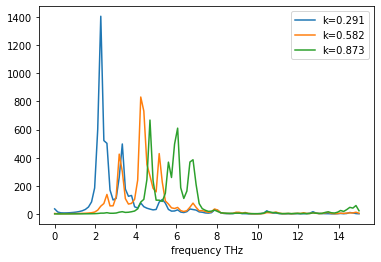

In [21]:
import matplotlib.pyplot as plt
plt.plot(mesh_energy,dsf_T[1,:],label='k={0:.3f}'.format(kvec[1]))
plt.plot(mesh_energy,dsf_T[3,:],label='k={0:.3f}'.format(kvec[3]))
plt.plot(mesh_energy,dsf_T[5,:],label='k={0:.3f}'.format(kvec[5]))

plt.xlabel('frequency THz')
plt.legend()
plt.savefig('S_T_v2_cSi.png',dpi=600)

アモルファスの場合はどちらがよいか悩むところ